In [1]:
!pip install openicl

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [28]:
from openicl import (DatasetReader, PromptTemplate, 
                     ZeroRetriever, RandomRetriever, BM25Retriever,
                     GenInferencer, PPLInferencer)
from openicl.icl_dataset_reader import load_dataset
import pandas as pd
from accelerate import Accelerator
from QPKTabuRetriever import QPKTabuRetriever
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
# Number of tests 
TEST_SIZE = [10] #[0.2]

#List of Number of In-Context Examples, 
NUM_ICE = np.arange(1,3)

#Number of repititions
REPS = 2

# Model tasks and dataset choice
MODELS = ["roberta-large"] #, "gpt2-large"]
TASKS = ['question-answering', 'sentiment-analysis']
DATASET_NAMES = {
    'question-answering':['commonsense_qa','tasksource/bigbench'],
    'sentiment-analysis':['imdb', 'gpt3mix/sst2']
}
RETRIEVERS = ['zero', 'random', 'bm25'] # 'qkp']


# Name of plots for dataset task combination
PLOT_NAMES_DATASET_TASK =    {
    'question-answering/commonsense_qa':'qa_com' ,
    'question-answering/tasksource/bigbench':'qa_at',
    'sentiment-analysis/imdb':'ss_imdb',
    'sentiment-analysis/gpt3mix/sst2': 'ss_gs'

}

In [14]:
def cmqa_pre_process(example):
    for i in range(5):
        example[chr(ord('A') + i)] = example['choices']['text'][i]
    return example

def bb_pre_process(example):
    for i in range(3):
        example[chr(ord('A') + i)] = example['multiple_choice_targets'][i]
    example['multiple_choice_scores'] = chr(ord('A') + np.where(np.array(example['multiple_choice_scores']) == 1)[0][0])
    example['context'] = "Disambiguation"
    return example

In [15]:
def select_dataset(name, test_size):
    if name == 'commonsense_qa':
        dataset = load_dataset(name, split='train')
        dataset = dataset.train_test_split(test_size=test_size, train_size=None, shuffle=True)
        dataset = dataset.map(cmqa_pre_process)
        dataset = dataset.rename_column("question_concept","context")
        dataset = dataset.rename_column("answerKey","answer")
        input_cols = ["question", "context", "A", "B", "C", "D", "E"]
        return DatasetReader(dataset=dataset, input_columns=input_cols, output_column="answer")
    elif name == 'tasksource/bigbench':
        dataset = load_dataset(name, 'disambiguation_qa', split='train')
        dataset = dataset.train_test_split(test_size=test_size, train_size=None, shuffle=True)
        dataset = dataset.map(bb_pre_process)
        dataset = dataset.rename_column("multiple_choice_scores","answer")
        dataset = dataset.rename_column("inputs","question")
        input_cols = ["question", "context", "A", "B", "C"]
        return DatasetReader(dataset=dataset, input_columns=input_cols, output_column="answer")
    elif name == 'imdb' or name == 'gpt3mix/sst2':
        dataset = load_dataset(name, split='train')
        dataset = dataset.train_test_split(test_size=test_size, train_size=None, shuffle=True)
        return DatasetReader(dataset=dataset, input_columns=["text"], output_column="label")


In [7]:
TEMPLATES = {
    'commonsense_qa':PromptTemplate(
        {
            'A': "</E>Answer the following question:\n</Q>\nAnswer: </Ans1>",
            'B': "</E>Answer the following question:\n</Q>\nAnswer: </Ans2>",
            'C': "</E>Answer the following question:\n</Q>\nAnswer: </Ans3>",
            'D': "</E>Answer the following question:\n</Q>\nAnswer: </Ans4>",
            'E': "</E>Answer the following question:\n</Q>\nAnswer: </Ans5>",
        },
        {'question':'</Q>', 'A': '</Ans1>', 'B': '</Ans2>', 'C': '</Ans3>', 'D': '</Ans4>', 'E': '</Ans5>'},
        ice_token='</E>' 
    ),
    'tasksource/bigbench':PromptTemplate(
        {
            'A': "</E>Answer the following question:\n</Q>\nAnswer: </Ans1>",
            'B': "</E>Answer the following question:\n</Q>\nAnswer: </Ans2>",
            'C': "</E>Answer the following question:\n</Q>\nAnswer: </Ans3>"
        },
        {'question':'</Q>', 'A': '</Ans1>', 'B': '</Ans2>', 'C': '</Ans3>'},
        ice_token='</E>' 
    ),
    'imdb':PromptTemplate({
            0: '</E>Positive Movie Review: \"<X>\"', 
            1: '</E>Negative Movie Review: \"<X>\"',
        }, column_token_map={'text' : '<X>'}, 
        ice_token='</E>'
    ),
    'gpt3mix/sst2':PromptTemplate({
            0: '</E>Positive Movie Review: \"<X>\"', 
            1: '</E>Negative Movie Review: \"<X>\"',
        }, column_token_map={'text' : '<X>'}, 
        ice_token='</E>'
    ),
}

In [8]:
def select_retriever(retr_name, data, model, task, ice_num, accelerator):
    if retr_name == 'zero':
        return ZeroRetriever(data)
    elif retr_name == 'random':
        return RandomRetriever(data, ice_num=ice_num, accelerator=accelerator)
    elif retr_name == 'bm25':
        return BM25Retriever(data, ice_num=ice_num, accelerator=accelerator)
    elif retr_name == 'qkp':
        return QPKTabuRetriever(data, model=model, task=task, ice_num=ice_num, accelerator=accelerator)
    else:
        raise Exception()

In [34]:
del inferencer
del data
del retriever
del ice_template
del predictions
torch.cuda.empty_cache()

In [33]:
results = []

accelerator = Accelerator()
print('Models:', MODELS)
print('TaskS: ', TASKS)
print('Retriever name: ', RETRIEVERS)
print('number of examples', NUM_ICE)
print('Repitions', REPS)

for test in TEST_SIZE:
            print('Test size: ', test)
            for model in MODELS:
                print('Model:', model)
                inferencer = PPLInferencer(model_name=model, accelerator=accelerator)
                
                for task in TASKS:
                    print('Task: ', task)
                    for dataset_name in DATASET_NAMES[task]:
                        data = select_dataset(dataset_name,  test)

                        for retr_name in RETRIEVERS:
                            print('Retriever name: ', retr_name)
                            accuracies = list()
                            all_predictions = list()
                            all_inputs = list()

                            for ice in NUM_ICE:
                                print('number of examples', ice)
                                retriever = select_retriever(retr_name, data, model, task, ice, accelerator)
                                ice_template = TEMPLATES[dataset_name] 

                                for _ in range(REPS):
                                    predictions = inferencer.inference(retriever, ice_template=ice_template)
                                    all_predictions.append(predictions)
                                    all_inputs.append(retriever.test_ds[retriever.dataset_reader.input_columns[0]])
                                    accuracies.append(np.sum(np.sum(np.array(retriever.test_ds[retriever.dataset_reader.output_column]) == np.array(predictions)))/ TEST_SIZE)
                                    del predictions
                                    torch.cuda.empty_cache() 

                                results.append({
                                        'model': model,
                                        'test_size': test,
                                        'ice_num': ice,
                                        'task': task,
                                        'dataset': dataset_name,
                                        'retriever': retr_name,
                                        'accuracy_mean': np.mean(accuracies),
                                        'accuracy_std':np.std(accuracies),
                                        'predictions':all_predictions,
                                        'inputs':all_inputs
                                    })
                                del retriever
                                del ice_template
                                torch.cuda.empty_cache() 
                        del data
                        torch.cuda.empty_cache() 
                del inferencer
                torch.cuda.empty_cache() 
    
results = pd.DataFrame(results)
results.to_csv('results.csv')


Models: ['roberta-large']
TaskS:  ['question-answering', 'sentiment-analysis']
Retriever name:  ['zero', 'random', 'bm25']
number of examples [1 2]
Repitions 2
Test size:  10
Model: roberta-large


In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv('results.csv')


In [ ]:
def bar_plot_results(results,  title_column1: str, x_axis : str , y_axis : str, z_axis : str, width=0.25, show= True, save_path=None):
    unique_t1 = set(map(str,results[title_column1]))
    # Tasks
    unique_x_axis = set(map(str,results[x_axis]))
    #acc
    unique_y_axis = set(map(str,results[y_axis]))
    # Model
    unique_z_axis = set(map(str,results[z_axis]))

    print('t1-axis: ', unique_t1)
    print('x-axis: ', unique_x_axis)
    print('y-axis: ', unique_y_axis)
    print('z-axis: ', unique_z_axis)
    colors = ['r','b', 'g', 'c', 'm', 'y', 'k', 'w']
    N = len(unique_x_axis)
    ind = np.arange(N) 

    print('N:' , N)
    # 3 dimensions:
    # `Task/Dataset`
    # 'Retriever'
    # 'Model'
    # Choose 2 to display 
    for t1 in unique_t1:
            print('t1: ', t1)
            plt.figure()
            vals = []
            stds = []
            bars = []
            for i, z in enumerate( unique_z_axis):
                # for x in unique_x_axis:
                    xvals = list(results.loc[(results[title_column1] == t1) & (results[z_axis] == z)]['accuracy_mean'])
                    xstd = list(results.loc[(results[title_column1] == t1)  & (results[z_axis] == z)]['accuracy_std'])
                    print(xvals)
                    print(xstd)
                    bar = plt.bar(ind+ width*i, xvals, width, color = colors[i])
                    bars.append(bar)
            

            plt.xlabel(x_axis)
            plt.ylabel(y_axis)
            plt.title(title_column1 +": " +str(t1) ) # + " and " + title_column2+  ": " + str(t2) )
            
            plt.xticks(ind+width, list(unique_x_axis))
            plt.legend( bars, unique_z_axis )

            if save_path is not None:
                        plt.savefig(save_path + 'barplot_' + t1 + '_' + x_axis + '_' + z_axis + '.png')
            plt.show()
                      

t1-axis:  {'roberta-large'}
x-axis:  {'qa_at', 'ss_gs', 'qa_com', 'ss_imdb'}
y-axis:  {'3.0', '9.0', '6.0', '1.0', '5.0', '2.0'}
z-axis:  {'zero', 'bm25', 'random'}
N: 4
t1:  roberta-large


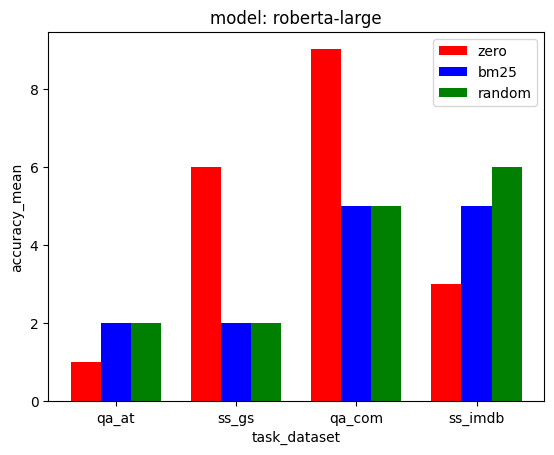

t1-axis:  {'roberta-large'}
x-axis:  {'zero', 'bm25', 'random'}
y-axis:  {'3.0', '9.0', '6.0', '1.0', '5.0', '2.0'}
z-axis:  {'qa_at', 'ss_gs', 'qa_com', 'ss_imdb'}
N: 3
t1:  roberta-large


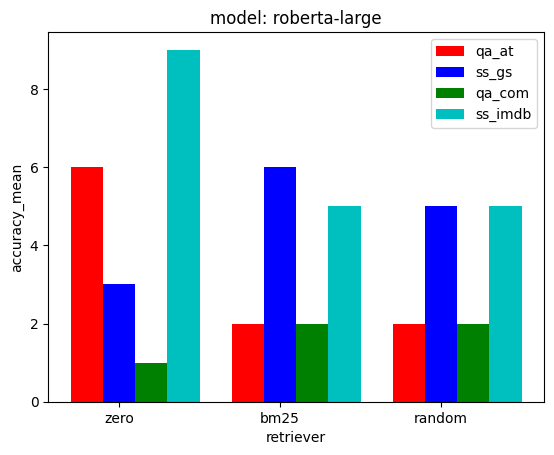

t1-axis:  {'roberta-large'}
x-axis:  {'zero', 'bm25', 'random'}
y-axis:  {'3.0', '9.0', '6.0', '1.0', '5.0', '2.0'}
z-axis:  {'qa_at', 'ss_gs', 'qa_com', 'ss_imdb'}
N: 3
t1:  roberta-large


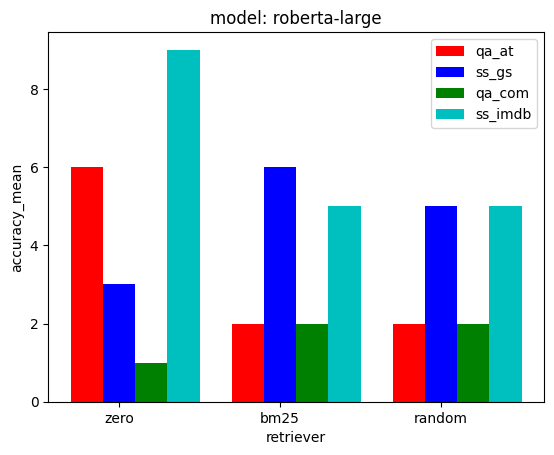

In [ ]:
df_results['task_dataset'] = df_results['task'].astype(str) +"/"+ df_results["dataset"]
df_results['task_dataset'] = df_results['task_dataset'].map(PLOT_NAMES_DATASET_TASK)

# SELECT constant test size and train size to plot
bar_df_filtered_results = df_results.loc[(df_results['test_size'] == TEST_SIZE[0]) & (df_results['ice_num'] == TRAIN_SIZE[0])]

bar_plot_results(results=bar_df_filtered_results, title_column1='model', x_axis='task_dataset', y_axis='accuracy_mean', z_axis='retriever', show=False, save_path='images/second_')
bar_plot_results(results=bar_df_filtered_results, title_column1='model', x_axis='retriever', y_axis='accuracy_mean', z_axis='task_dataset', width=0.2 , save_path='images/second_')
bar_plot_results(results=bar_df_filtered_results, title_column1='model', x_axis='retriever', y_axis='accuracy_mean', z_axis='task_dataset', width=0.2 , save_path='images/second_')


In [ ]:



def line_plot_results(results,  title_column1, title_column2, title_column3, x_axis : str , y_axis : str, z_axis : str, save_path=None):
    unique_t1 = set(map(str,results[title_column1]))
    unique_t2 = set(map(str,results[title_column2]))
    # unique_t3 = set(map(str,results[title_column3]))
    # Test_size
    unique_x_axis = set(results[x_axis])
    # acc
    unique_y_axis = set(results[y_axis])
    # retriever
    unique_z_axis = set(results[z_axis])

    print('t1-axis: ', unique_t1)
    print('x-axis: ', unique_x_axis)
    print('y-axis: ', unique_y_axis)
    print('z-axis: ', unique_z_axis)
    colors = ['r','b', 'g', 'c', 'm', 'y', 'k', 'w']
    N = len(unique_x_axis)
    ind = np.arange(N) 

    print('N:' , N)
    # 5 possible dimensions:
    # `Task/Dataset`
    # 'Retriever'
    # 'Model'
    # 'Test_size'
    # 'num_ice'

    # Choose 2 to display 
    for t1 in unique_t1:
        for t2 in unique_t2:
            # for t3 in unique_t3:
                plt.figure()
                for i,z in enumerate(unique_z_axis):
                    # xvals  = list(set(results.loc[(results[title_column1] == t1) & (results[title_column2] == t2) & (results[z_axis] == z)][x_axis]))
                    vals =  list(results.loc[(results[title_column1] == t1) & (results[title_column2] == t2)  & (results[z_axis] == z)]['accuracy_mean'])
                    std = list(results.loc[(results[title_column1] == t1)  & (results[title_column2] == t2)  & (results[z_axis] == z)]['accuracy_std'])
                    xvals = list(results.loc[(results[title_column1] == t1)  & (results[title_column2] == t2)  & (results[z_axis] == z)][x_axis])
                    plt.plot(xvals, vals , color = colors[i])


                plt.xlabel(x_axis)
                plt.ylabel(y_axis)
                plt.title(title_column1 +": " + str(t1) + ", " + title_column2 +  ": " + str(t2) ) #+ " and " + title_column3+  ": " + str(t3) )
                
                plt.legend(unique_z_axis )
                plt.show()
                if save_path is not None:
                            plt.savefig(save_path + 'lineplot_' + t1 + '_' + t2 + '_'+ x_axis + '_' + z_axis + '.png')


In [ ]:
df_results['task_dataset'] = df_results['task'].astype(str) +"/"+ df_results["dataset"]
df_results['task_dataset'] = df_results['task_dataset'].map(PLOT_NAMES_DATASET_TASK)

# SELECT constant test size and train size to plot
line_df_filtered_results = df_results.loc[(df_results['test_size'] == TEST_SIZE[0]) & (df_results['train_size'] == TRAIN_SIZE[0])]

line_plot_results(results=line_df_filtered_results, title_column1='model', title_column2='task_dataset',title_column3='Retriever',  x_axis='ice_num', y_axis='accuracy_mean', z_axis='test_size', show=False, save_path='images/')
line_plot_results(results=line_df_filtered_results, title_column1='model', title_column2='task_dataset',title_column3='Retriever',  x_axis='test_size', y_axis='accuracy_mean', z_axis='ice_num', show=False, save_path='images/')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9bb66d69-4e10-4867-b27a-34e04d606f05' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>